In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.6 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

import efficientnet.tfkeras as efn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPooling2D, Conv2D, AveragePooling2D, GlobalAveragePooling2D

In [4]:
train_dir = '/content/drive/MyDrive/Dataset/train'
val_dir = '/content/drive/MyDrive/Dataset/val' 
test_dir = '/content/drive/MyDrive/Dataset/test'

class_name = os.listdir(train_dir)

In [5]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

validation_datagen  = ImageDataGenerator( rescale = 1./255 )
test_datagen = ImageDataGenerator(rescale=1./255)


In [6]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 32,
                                                    class_mode = 'categorical',
                                                    shuffle=True, 
                                                    target_size = (512, 512))   

validation_generator = test_datagen.flow_from_directory(val_dir,
                                                        batch_size = 32,
                                                        class_mode = 'categorical',
                                                        shuffle=True,  
                                                        target_size = (512, 512))

test_generator = test_datagen.flow_from_directory(test_dir,
                                                        batch_size = 32,
                                                        class_mode = 'categorical',
                                                        shuffle=True,  
                                                        target_size = (512, 512))

Found 1818 images belonging to 4 classes.
Found 224 images belonging to 4 classes.
Found 230 images belonging to 4 classes.


In [7]:
base_model = efn.EfficientNetB7(
        input_shape=(512, 512, 3),
        weights='imagenet',
        include_top=False)

258434480/258434480 [==============================] - 10s 0us/step


In [8]:
for layer in base_model.layers:
  layer.trainable = False

In [9]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)

# **MODEL 1**

In [10]:
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(4,activation='softmax'))


model.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b7 (Functional  (None, 16, 16, 2560)     64097680  
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 2560)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2560)              0         
                                                                 
 dense (Dense)               (None, 512)               1311232   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               6

In [12]:
history = model.fit(
            train_generator,
            epochs=100,
            validation_data=validation_generator,
            callbacks = [callback]
            )

Epoch 1/100
57/57 [==============================] - 1210s 21s/step - loss: 1.3530 - accuracy: 0.3526 - val_loss: 1.2368 - val_accuracy: 0.5045
Epoch 2/100
57/57 [==============================] - 188s 3s/step - loss: 1.2297 - accuracy: 0.4659 - val_loss: 1.0726 - val_accuracy: 0.5536
Epoch 3/100
57/57 [==============================] - 179s 3s/step - loss: 1.1297 - accuracy: 0.5231 - val_loss: 1.0098 - val_accuracy: 0.5759
Epoch 4/100
57/57 [==============================] - 179s 3s/step - loss: 1.0471 - accuracy: 0.5792 - val_loss: 0.9132 - val_accuracy: 0.6429
Epoch 5/100
57/57 [==============================] - 185s 3s/step - loss: 1.0321 - accuracy: 0.5693 - val_loss: 0.9030 - val_accuracy: 0.6295
Epoch 6/100
57/57 [==============================] - 179s 3s/step - loss: 1.0054 - accuracy: 0.5880 - val_loss: 0.8694 - val_accuracy: 0.6205
Epoch 7/100
57/57 [==============================] - 186s 3s/step - loss: 0.9728 - accuracy: 0.5968 - val_loss: 0.8332 - val_accuracy: 0.6473
Epoc

In [13]:
model.save("Model2.h5")

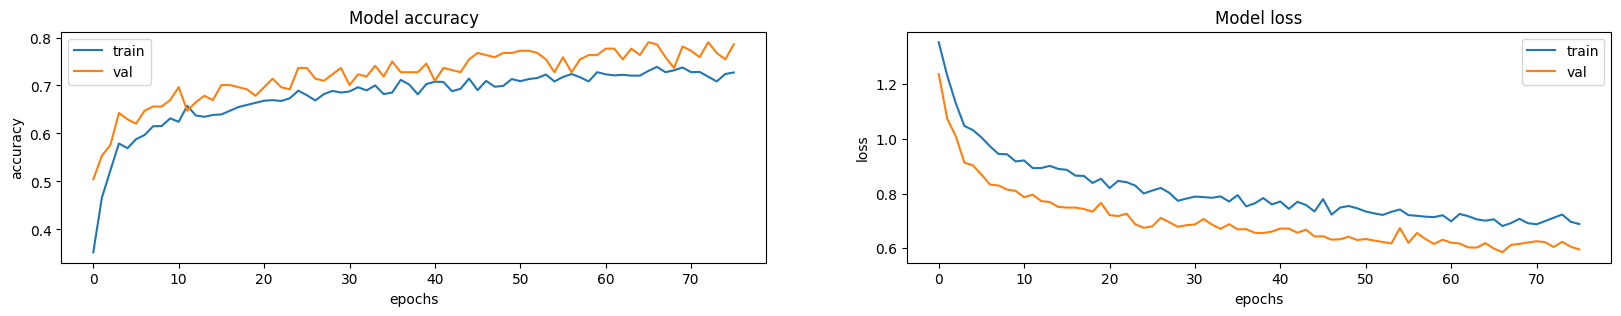

In [14]:
import matplotlib.pyplot as plt
import matplotlib

fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [15]:
model.evaluate(test_generator)

8/8 [==============================] - 147s 21s/step - loss: 0.4974 - accuracy: 0.8217


[0.49737775325775146, 0.821739137172699]